In [2]:
"""
#50 News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
抽出された事例をランダムに並び替える．
抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．
ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．
学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．
"""

import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("news+aggregator/newsCorpora.csv",
                   header=None,
                   sep="\t",
                   names=[
                       "ID",
                       "TITLE",
                       "URL",
                       "PUBLISHER",
                       "CATEGORY",
                       "STORY",
                       "HOSTNAME",
                       "TIMESTAMP",
                       ])

df = data.loc[
    data["PUBLISHER"].isin(
        ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
    ),
    ["TITLE", "CATEGORY"],
]

train, valid_test = train_test_split(
    df,
    train_size=0.8,
    random_state=1,
    shuffle=True,
    stratify=df["CATEGORY"],  # stratifyはカテゴリの割合が各データで等しくなるように
)

valid, test = train_test_split(
    valid_test,
    test_size=0.5,
    random_state=1,
    shuffle=True,
    stratify=valid_test["CATEGORY"],
)

# データの保存
train.to_csv("./train.txt", sep="\t", index=False)
valid.to_csv("./valid.txt", sep="\t", index=False)
test.to_csv("./test.txt", sep="\t", index=False)

# 事例数の確認
if __name__ == "__main__":
    print("学習データ")
    print(train["CATEGORY"].value_counts())
    print("検証データ")
    print(valid["CATEGORY"].value_counts())
    print("評価データ")
    print(test["CATEGORY"].value_counts())



学習データ
CATEGORY
b    4502
e    4223
t    1219
m     728
Name: count, dtype: int64
検証データ
CATEGORY
b    563
e    528
t    152
m     91
Name: count, dtype: int64
評価データ
CATEGORY
b    562
e    528
t    153
m     91
Name: count, dtype: int64


In [4]:
"""
51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ．
 なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．
"""
import string
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
#from knock50 import train, test, valid


def preprocessing(text):
    """記号除去，小文字化，数字を統一する前処理関数"""
    table = str.maketrans(
        string.punctuation, " " * len(string.punctuation)
    )  # string.punctuationは記号の文字列，そのそれぞれの記号をキー，スペースを値とした辞書を作成
    text = text.translate(table)  # tableにあるキーに該当したらそのキーに対応する値(スペース)に変換する．
    text = text.lower()  # 小文字化
    text = re.sub("[0-9]+", "0", text)  # 数字列を0に統一

    return text


# 前処理
train["TITLE"] = train["TITLE"].map(preprocessing)
valid["TITLE"] = valid["TITLE"].map(preprocessing)
test["TITLE"] = test["TITLE"].map(preprocessing)

# 10回以上登場したもので，unigramとbigramの両方を考える
vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

# データを入力してtf-idf行列を得る
X_train = vec_tfidf.fit_transform(train["TITLE"])
X_valid = vec_tfidf.transform(valid["TITLE"])
X_test = vec_tfidf.transform(test["TITLE"])

# データフレームに戻す
X_train = pd.DataFrame(X_train.toarray(), columns=vec_tfidf.get_feature_names_out())
X_valid = pd.DataFrame(X_valid.toarray(), columns=vec_tfidf.get_feature_names_out())
X_test = pd.DataFrame(X_test.toarray(), columns=vec_tfidf.get_feature_names_out())

# csvで出力
X_train.to_csv("X_train.txt", sep="\t", index=False)
X_valid.to_csv("X_valid.txt", sep="\t", index=False)
X_test.to_csv("X_test.txt", sep="\t", index=False)

In [5]:
"""
52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．
"""

from sklearn.linear_model import LogisticRegression
#from knock51 import X_train, train

# モデルの学習
lr = LogisticRegression(max_iter=1000)  # デフォルトのmax_iter=100だとエラーになる
lr.fit(X_train, train["CATEGORY"]) 

LogisticRegression(max_iter=1000)

In [12]:
"""
53. 
52で学習したロジスティック回帰モデルを用い、
与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．
"""

import numpy as np
#from knock51 import X_train, X_test, X_valid
#from knock52 import lr


def pred_and_prob_lr(lr, X):
    '''第一要素に予測されるラベルのリストとするリスト、 第二要素を予測確率のndarrayを返す'''
    return [lr.predict(X),
            np.max(lr.predict_proba(X), axis=1)]


train_pred = pred_and_prob_lr(lr, X_train)
test_pred = pred_and_prob_lr(lr, X_test)
valid_pred = pred_and_prob_lr(lr, X_valid)

print(f'train_pred score:{train_pred}')

train_pred score:[array(['b', 'b', 'e', ..., 'b', 'e', 'b'], dtype=object), array([0.92870349, 0.84509458, 0.89029995, ..., 0.95926224, 0.45651044,
       0.94866739])]


In [9]:
"""
54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，
学習データおよび評価データ上で計測せよ
"""

#from knock51 import X_train, X_test, train, test
#from knock52 import lr

print('train data score：', lr.score(X_train, train['CATEGORY']))
print('test data score：', lr.score(X_test, test['CATEGORY']))

train data score： 0.9231634182908546
test data score： 0.8740629685157422


In [10]:
"""
55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，
学習データおよび評価データ上で作成せよ．
"""

#from knock51 import X_train, X_test, train, test
#from knock52 import lr
from sklearn.metrics import confusion_matrix

pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

cm_train = confusion_matrix(pred_train, train['CATEGORY'])
cm_test = confusion_matrix(pred_test, test['CATEGORY'])

print(cm_train)
print(cm_test)

[[4339   58  101  190]
 [  98 4152  132  146]
 [   9    2  484    6]
 [  56   11   11  877]]
[[516   8  16  37]
 [ 25 515  26  24]
 [  3   1  45   2]
 [ 18   4   4  90]]


In [41]:
"""
56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．
カテゴリごとに適合率，再現率，F1スコアを求め，
カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．
"""

#from knock51 import test
#from knock53 import test_pred
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pandas as pd


def calculate_scores(y_true, y_pred):

    # 適合率
    precision = precision_score(
        y_true, 
        y_pred, 
        average=None, 
        labels=["b", "e", "t", "m"]
    )  # Noneを指定するとクラスごとの精度をndarrayで返す

    precision = np.append(
        precision, 
        precision_score(y_true, y_pred, average="micro")
    )  

    precision = np.append(
        precision, 
        precision_score(y_true, y_pred, average="macro")
    )  

    # 再現率
    recall = recall_score(
        y_true, 
        y_pred, 
        average=None, 
        labels=["b", "e", "t", "m"]
    )

    recall = np.append(recall, 
                       recall_score(y_true, y_pred, average="micro"))
    
    recall = np.append(recall, 
                       recall_score(y_true, y_pred, average="macro"))

    # F1スコア
    f1 = f1_score(
        y_true, 
        y_pred, 
        average=None, 
        labels=["b", "e", "t", "m"]
    )
    f1 = np.append(f1, 
                   f1_score(y_true, y_pred, average="micro"))
    f1 = np.append(f1, 
                   f1_score(y_true, y_pred, average="macro"))

    # 結果を結合してデータフレーム化
    scores = pd.DataFrame(
        {"適合率": precision, "再現率": recall, "F1スコア": f1},
        index=["b", "e", "t", "m", "マイクロ平均", "マクロ平均"],
    )

    return scores

print(calculate_scores(test["CATEGORY"], test_pred[0]))

             適合率       再現率     F1スコア
b       0.894281  0.918149  0.906058
e       0.872881  0.975379  0.921288
t       0.775862  0.588235  0.669145
m       0.882353  0.494505  0.633803
マイクロ平均  0.874063  0.874063  0.874063
マクロ平均   0.856344  0.744067  0.782573


In [42]:
"""
57. 特徴量の重みの確認P
52で学習したロジスティック回帰モデルの中で，
重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ
"""

#from knock51 import X_train
#from knock52 import lr
import numpy as np
import pandas as pd


features = X_train.columns.values
print(X_train.columns)

index = [i for i in range(1, 11)]

for c, coef in zip(lr.classes_, lr.coef_):  # lr.classes_:クラスラベル, lr.coef_:重み
    print(f"【カテゴリ】{c}")
    
    # np.argsortで重みが昇順になるようにインデックスのndarrayが返される．
    # 転置して行データ状にする
    best10 = pd.DataFrame(
        features[np.argsort(coef)[::-1][:10]], columns=["重要度上位"], index=index
    ).T
    worst10 = pd.DataFrame(
        features[np.argsort(coef)[:10]], columns=["重要度下位"], index=index
    ).T
    print(pd.concat([best10, worst10], axis=0))  # 上下方向にconcatする
    print("\n")

Index(['0m', '0million', '0nd', '0s', '0st', '0th', '0th birthday', 'aa',
       'aaliyah', 'abbvie',
       ...
       'you to', 'young', 'your', 'your mother', 'yr', 'yuan', 'zac',
       'zac efron', 'zendaya', 'zone'],
      dtype='object', length=2511)
【カテゴリ】b
        1       2      3      4       5          6      7          8       9   \
重要度上位  fed    bank    ecb  china  stocks       euro    oil  obamacare  dollar   
重要度下位  and  google  ebola  video     her  microsoft  study       star     the   

             10  
重要度上位   ukraine  
重要度下位  facebook  


【カテゴリ】e
               1       2       3     4      5      6         7      8     9   \
重要度上位  kardashian   chris   movie  star   film   fans        he    kim   jay   
重要度下位          us  update  google    gm  china  study  facebook  apple  data   

         10  
重要度上位   her  
重要度下位  says  


【カテゴリ】m
             1      2       3     4     5     6        7      8        9   \
重要度上位     ebola  study  cancer  drug   fda  mers      cd

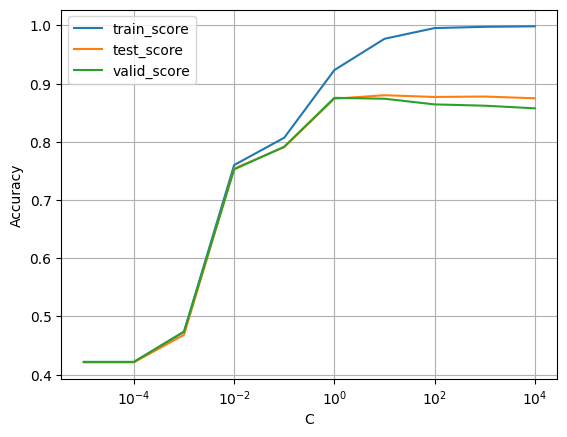

In [45]:
"""
58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．
異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．
実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．
"""

from sklearn.linear_model import LogisticRegression
#from knock51 import X_train, X_test, X_valid, train, test, valid
#from knock52 import lr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

score_train = []
score_test = []
score_valid = []

C_list = np.logspace(-5, 4, 10, base=10)
for C in C_list:
    lr = LogisticRegression(C=C, max_iter=10000)
    lr.fit(X_train, train["CATEGORY"])
    score_train.append(lr.score(X_train, train["CATEGORY"]))
    score_test.append(lr.score(X_test, test["CATEGORY"]))
    score_valid.append(lr.score(X_valid, valid["CATEGORY"]))

fig, ax = plt.subplots()
ax.plot(C_list, score_train, label="train_score")
ax.plot(C_list, score_test, label="test_score")
ax.plot(C_list, score_valid, label="valid_score")
plt.xscale('log')
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
plt.grid()
plt.legend()
#plt.savefig('Figure_1.png')
plt.show()

In [48]:
%pip install optuna

  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/15/da/68883911855d8b4d521f9a370e4e6aab8232b91c1d8d5a8348c4680c6642/optuna-3.6.1-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/7f/50/9fb3a5c80df6eb6516693270621676980acd6d5a9a7efdbfa273f8d616c7/alembic-1.13.1-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/f3/18/3e867ab37a24fdf073c1617b9c7830e06ec270b1ea4694a624038fc40a03/colorlog-6.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for sqlalchemy>=1.3.0 from https://files.pythonhosted.org/packages/cd/ae/062f6ebd474aef81a199a16d2b1fb521d5fb0bc38a470181b0bcbfe3eb11/SQLAlchemy-2.0.30-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for Mako from https://files.pythonhosted.org/packages/03/62/70f5a0c2dd208f9f3f2f9afd103aec42ee4d9ad2401d78342f75e9b8da36/Mako-1.3

In [49]:
"""
59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．
検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．
また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．
"""

from cmath import log
#from knock51 import X_train, X_valid, train, valid
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


# 最適化関数
def objective(trial):

    # ハイパーパラメータのセット
    C = trial.suggest_float("C", 1e-4, 1e4, log=True)

    # モデルの学習
    svc = SVC(random_state=1, max_iter=10000, C=C, gamma="auto")
    svc.fit(X_train, train["CATEGORY"])

    # 正解率の算出
    valid_accuracy = svc.score(X_valid, valid["CATEGORY"])

    return valid_accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=4)

print("最適値：", study.best_value)
print("最適パラメータ", study.best_params)

/Users/sane/opt/anaconda3/envs/kaneko_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-06-03 14:38:58,936] A new study created in memory with name: no-name-0d7e2502-c90e-46ad-82d1-904434d65508
[I 2024-06-03 14:42:48,470] Trial 0 finished with value: 0.42203898050974514 and parameters: {'C': 0.12128102271323626}. Best is trial 0 with value: 0.42203898050974514.
[I 2024-06-03 14:46:37,809] Trial 1 finished with value: 0.42203898050974514 and parameters: {'C': 0.2768293440267968}. Best is trial 0 with value: 0.42203898050974514.
[I 2024-06-03 14:51:50,832] Trial 2 finished with value: 0.42203898050974514 and parameters: {'C': 0.01653053751584299}. Best is trial 0 with value: 0.42203898050974514.
[I 2024-06-03 14:55:36,048] Trial 3 finished with value: 0.42203898050974514 and parameters: {'C': 0.

最適値： 0.42203898050974514
最適パラメータ {'C': 0.12128102271323626}
